In [35]:
import pandas as pd, numpy as np
import os, json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime, timedelta
os.getcwd()
from data_loader.forecast_dataloader import ForecastDataset, de_normalized
pd.set_option('display.max_columns', 50)

In [3]:
TRAIN_RATIO = 0.7
VALID_RATIO = 0.2
TEST_RATIO = 1 - (TRAIN_RATIO + VALID_RATIO)

WINDOW_SIZE = 24
HORIZON = 6
NORM_METHOD = 'z_score'
DATASET = 'Houston'
START_POI = 0
END_POI = 400
BATCH_SIZE = 1
START_DATE = '2018-12-31'

TOTAL_DAYS = 400

CAT_COLS = ['top_category', 'sub_category']

RESULT_TRAIN_FILE = f'output/{DATASET}/train_{START_POI}_{END_POI}'
RESULT_TEST_FILE = f'output/{DATASET}/test_{START_POI}_{END_POI}'

In [4]:
date_format = r'%Y-%m-%d'
start_time = datetime.strptime(START_DATE, date_format)
end_time = start_time + timedelta(days=TOTAL_DAYS)
start_time, end_time

(datetime.datetime(2018, 12, 31, 0, 0), datetime.datetime(2020, 2, 4, 0, 0))

In [5]:
train_days = int(TRAIN_RATIO * TOTAL_DAYS)
valid_days = int(TOTAL_DAYS * VALID_RATIO)
test_days = TOTAL_DAYS - train_days - valid_days

time_span = pd.date_range(start_time, end_time, freq='1H', closed='left').to_numpy()
valid_dates = time_span[train_days*24 + WINDOW_SIZE:(train_days + valid_days)*24 - HORIZON + 1]
test_dates = time_span[(train_days + valid_days)*24 + WINDOW_SIZE: - HORIZON + 1]
time_span

array(['2018-12-31T00:00:00.000000000', '2018-12-31T01:00:00.000000000',
       '2018-12-31T02:00:00.000000000', ...,
       '2020-02-03T21:00:00.000000000', '2020-02-03T22:00:00.000000000',
       '2020-02-03T23:00:00.000000000'], dtype='datetime64[ns]')

In [6]:
test_dates.shape

(931,)

In [7]:
df = pd.read_pickle(f'cache_data/data-{START_POI}-{END_POI}-{TOTAL_DAYS}-{DATASET}.pkl')
# df = df.iloc[START_POI:END_POI]

data = pd.DataFrame(df["visits_by_each_hour"].to_list()).T

# split data
days = int(data.shape[0] / 24)

train_days = int(TRAIN_RATIO * days)
valid_days = int(days*VALID_RATIO)
test_days = days-train_days-valid_days

train_data = data[:train_days*24]
valid_data = data[train_days*24:(train_days + valid_days)*24]
test_data = data[(train_days + valid_days)*24:(train_days + valid_days+test_days)*24]

with open(os.path.join(RESULT_TRAIN_FILE, 'norm_stat.json'),'r') as f:
    normalize_statistic = json.load(f)


test_set = ForecastDataset(test_data, window_size=WINDOW_SIZE, 
                            horizon=HORIZON,
                            normalize_method=NORM_METHOD, 
                            norm_statistic=normalize_statistic)

test_loader = torch_data.DataLoader(test_set, batch_size=BATCH_SIZE, drop_last=False,
                                    shuffle=False, num_workers=0)

valid_set = ForecastDataset(valid_data, window_size=WINDOW_SIZE, horizon=HORIZON,
                            normalize_method=NORM_METHOD, norm_statistic=normalize_statistic)
valid_loader = torch_data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = torch.load(f'output/{DATASET}/train_{START_POI}_{END_POI}/39_stemgnn.pt')

In [8]:
def get_sample_by_datetime(datetime_str, test_dates, test_loader):
    datetime_input = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')
    datetime_input_np = np.datetime64(datetime_input)

    for i, data in enumerate(test_loader):
        if test_dates[i] == datetime_input_np:
            return data

    raise ValueError("Datetime not found in test_dates array.")

In [9]:
test_dates

array(['2019-12-27T00:00:00.000000000', '2019-12-27T01:00:00.000000000',
       '2019-12-27T02:00:00.000000000', '2019-12-27T03:00:00.000000000',
       '2019-12-27T04:00:00.000000000', '2019-12-27T05:00:00.000000000',
       '2019-12-27T06:00:00.000000000', '2019-12-27T07:00:00.000000000',
       '2019-12-27T08:00:00.000000000', '2019-12-27T09:00:00.000000000',
       '2019-12-27T10:00:00.000000000', '2019-12-27T11:00:00.000000000',
       '2019-12-27T12:00:00.000000000', '2019-12-27T13:00:00.000000000',
       '2019-12-27T14:00:00.000000000', '2019-12-27T15:00:00.000000000',
       '2019-12-27T16:00:00.000000000', '2019-12-27T17:00:00.000000000',
       '2019-12-27T18:00:00.000000000', '2019-12-27T19:00:00.000000000',
       '2019-12-27T20:00:00.000000000', '2019-12-27T21:00:00.000000000',
       '2019-12-27T22:00:00.000000000', '2019-12-27T23:00:00.000000000',
       '2019-12-28T00:00:00.000000000', '2019-12-28T01:00:00.000000000',
       '2019-12-28T02:00:00.000000000', '2019-12-28

### Tuesday, Jan 21, 2020 12:00:00 PM (Lunch time in weekday)

In [10]:
x, y = get_sample_by_datetime('2020-01-21 12:00:00', test_dates, test_loader)
x.shape, y.shape

(torch.Size([1, 24, 445]), torch.Size([1, 6, 445]))

In [11]:
model.eval()
with torch.no_grad():
    forecast_result, _, (adj_mat_thresholded, adj_mat_unthresholded, embed_att, dist_adj, mhead_att_mat) = model(x)

In [12]:
adj_mat_thresholded = adj_mat_thresholded.cpu().numpy()
adj_mat_unthresholded = adj_mat_unthresholded.cpu().numpy()
embed_att = embed_att.cpu().numpy()
dist_adj = dist_adj.cpu().numpy()
mhead_att_mat = mhead_att_mat.cpu().numpy()

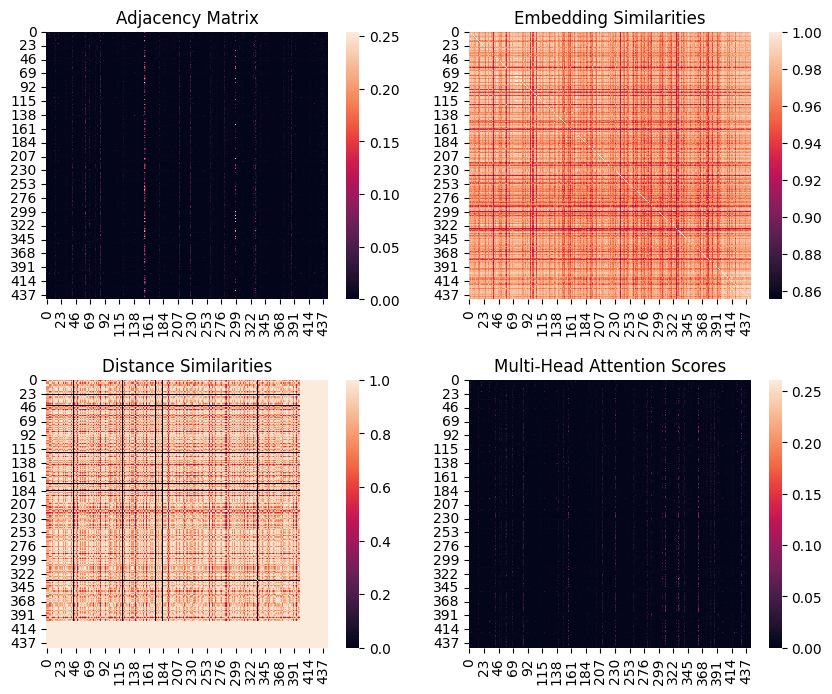

In [13]:
# Create a figure and set the layout
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot adj_mat_thresholded
sns.heatmap(adj_mat_thresholded, ax=axs[0, 0])
axs[0, 0].set_title('Adjacency Matrix')

# Plot embed_att
sns.heatmap(embed_att, ax=axs[0, 1])
axs[0, 1].set_title('Embedding Similarities')

# Plot dist_adj
sns.heatmap(dist_adj, ax=axs[1, 0])
axs[1, 0].set_title('Distance Similarities')

# Plot mhead_att_mat
sns.heatmap(mhead_att_mat, ax=axs[1, 1])
axs[1, 1].set_title('Multi-Head Attention Scores')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Show the plot
plt.show()

In [135]:
adj_mat_thresholded.sum(axis=0).argmax()


safegraph_place_id                         sg:699bd9f4c21248bb80ed84820aeb9d31
visits_by_day                [53, 408, 379, 375, 378, 16, 6, 386, 389, 357,...
visits_by_each_hour          [0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 16, 11...
raw_visit_counts                                                         94198
location_name                                                    Stratford H S
street_address                                                   14555 Fern Dr
city                                                                   Houston
region                                                                      TX
postal_code                                                            77079.0
iso_country_code                                                            US
safegraph_brand_ids                                                        NaN
brands                                                                     NaN
parent_safegraph_place_id                           

In [84]:
def find_similar_elements(adj_mat, embed_att, dist_adj, mhead_att, adj_threshold, embed_threshold, dist_threshold, att_threshold):
    # Find indices where all conditions are satisfied
    indices = np.where(
        (adj_mat > adj_threshold) & 
        (embed_att < embed_threshold) & 
        (dist_adj < dist_threshold) & 
        (mhead_att > att_threshold)
    )
    
    # Extract the row and column indices
    row_indices, col_indices = indices
    
    # Create a list of tuples with the matching indices
    matching_elements = list(zip(row_indices, col_indices))
    
    return matching_elements

def find_dissimilar_elements(adj_mat, embed_att, dist_adj, mhead_att, adj_threshold, embed_threshold, dist_threshold, att_threshold):
    # Find indices where all conditions are satisfied
    indices = np.where(
        (adj_mat < adj_threshold) & 
        (embed_att > embed_threshold) & 
        (dist_adj < dist_threshold) & 
        (mhead_att < att_threshold)
    )
    
    # Extract the row and column indices
    row_indices, col_indices = indices
    
    # Create a list of tuples with the matching indices
    matching_elements = list(zip(row_indices, col_indices))
    
    return matching_elements

def find_common_tuples(list1, list2):
    common_tuples = [
        tuple1 for tuple1 in list1
        for tuple2 in list2
        if any(elem in tuple2 for elem in tuple1)
    ]
    
    return common_tuples

# Example usage
thresholds = {
    'adj_threshold': 0.1,
    'embed_threshold': 1,
    'dist_threshold': 0.9,
    'att_threshold': 0.13
}

similar_elements = find_similar_elements(adj_mat_thresholded, embed_att, dist_adj, mhead_att_mat, **thresholds)
print(similar_elements)
# Example usage
thresholds = {
    'adj_threshold': 0.01,
    'embed_threshold': 0.99,
    'dist_threshold': 0.9,
    'att_threshold': 0.01
}

dissimilar_elements = find_dissimilar_elements(adj_mat_thresholded, embed_att, dist_adj, mhead_att_mat, **thresholds)
print(dissimilar_elements)


common = find_common_tuples(similar_elements, dissimilar_elements)
print(common)

[(14, 154), (15, 154), (25, 154), (41, 154), (57, 298), (59, 154), (61, 154), (61, 298), (68, 154), (77, 154), (84, 154), (85, 154), (85, 298), (112, 154), (118, 154), (121, 154), (141, 154), (162, 154), (175, 154), (193, 154), (201, 154), (201, 298), (210, 298), (220, 154), (222, 298), (227, 154), (231, 154), (234, 154), (252, 154), (255, 154), (257, 154), (262, 154), (262, 298), (263, 154), (271, 154), (280, 154), (281, 154), (286, 154), (309, 154), (310, 154), (310, 298), (327, 154), (330, 154), (331, 154), (331, 298), (332, 154), (332, 298), (340, 154), (360, 154), (363, 154), (374, 330), (381, 154), (382, 154), (384, 154)]
[(0, 4), (2, 19), (2, 47), (2, 79), (4, 0), (4, 9), (4, 138), (4, 207), (6, 7), (7, 6), (9, 86), (9, 256), (11, 19), (11, 66), (11, 346), (12, 9), (12, 44), (12, 60), (12, 66), (12, 67), (12, 69), (12, 86), (12, 197), (12, 218), (13, 19), (13, 27), (13, 47), (13, 66), (13, 70), (13, 79), (13, 95), (13, 109), (13, 164), (13, 236), (13, 311), (16, 30), (16, 39), (

In [54]:
mhead_att_mat.max()

0.26088017

In [122]:
# a, b, c = 336, 298, 76
# a, b, c = 154, 59, 121
a, b, c = 285, 288, 135
df.iloc[[a, b, c]]

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
285,sg:66fd384f20dd44c1b1c644e7227daf3d,"[24, 47, 20, 65, 37, 40, 8, 314, 313, 315, 294...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 9, 4, ...",60330,Starbucks,334 Melcher Hall,Houston,TX,77204.0,US,SG_BRAND_f116acfe9147494063e58da666d1d57e,Starbucks,NaN,Restaurants and Other Eating Places,Snack and Nonalcoholic Beverage Bars,722515.0,29.720995,-95.339488,1.713743e+10,NaN,"Snacks,Counter Service,Dessert,Tea House,Coffe..."
288,sg:080d0f2d1b4742ccb672feb897299abb,"[42, 73, 57, 67, 62, 30, 8, 61, 53, 64, 74, 68...","[0, 0, 0, 0, 0, 0, 0, 2, 4, 1, 1, 2, 3, 16, 3,...",60182,Alfred R Neumann Library,2700 Bay Area Blvd,Houston,TX,77058.0,US,NaN,NaN,NaN,Other Information Services,Libraries and Archives,519120.0,29.582447,-95.098422,1.281283e+10,NaN,NaN
135,sg:bf9cc50e6cfd4b25b07d3b363795fcec,"[213, 282, 306, 318, 294, 58, 37, 319, 335, 31...","[0, 0, 0, 0, 0, 4, 9, 7, 9, 15, 14, 15, 14, 59...",99627,Starbucks,6400 Fannin St Ste 104,Houston,TX,77030.0,US,SG_BRAND_f116acfe9147494063e58da666d1d57e,Starbucks,NaN,Restaurants and Other Eating Places,Snack and Nonalcoholic Beverage Bars,722515.0,29.715108,-95.397362,1.713797e+10,"{ ""Mon"": [[""4:30"", ""19:00""]], ""Tue"": [[""4:30"",...","Snacks,Counter Service,Dessert,Tea House,Coffe..."


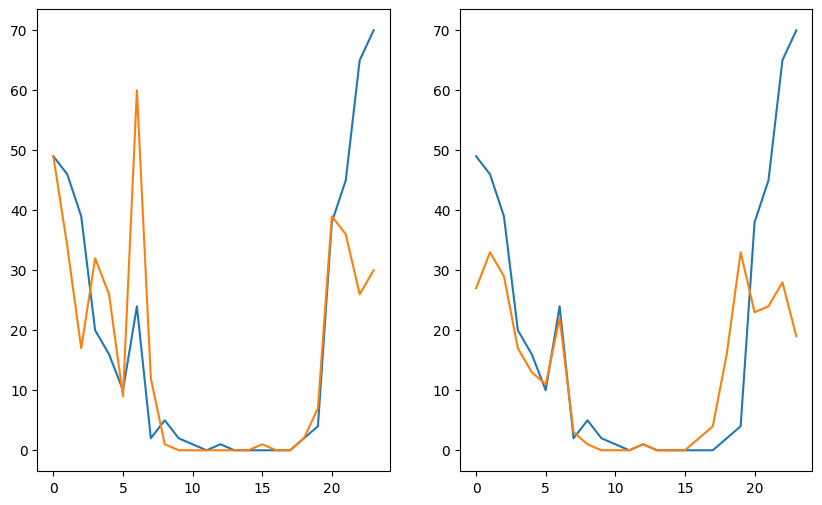

In [123]:
# plot the time series for POIs 33, 34, and 12 
# x = de_normalized(x.numpy(), NORM_METHOD, normalize_statistic)

fig, ax = plt.subplots(1, 2,figsize=(10, 6))
ax[0].plot(x[0, :, a])
ax[0].plot(x[0, :, b])
ax[1].plot(x[0, :, a])
ax[1].plot(x[0, :, c])

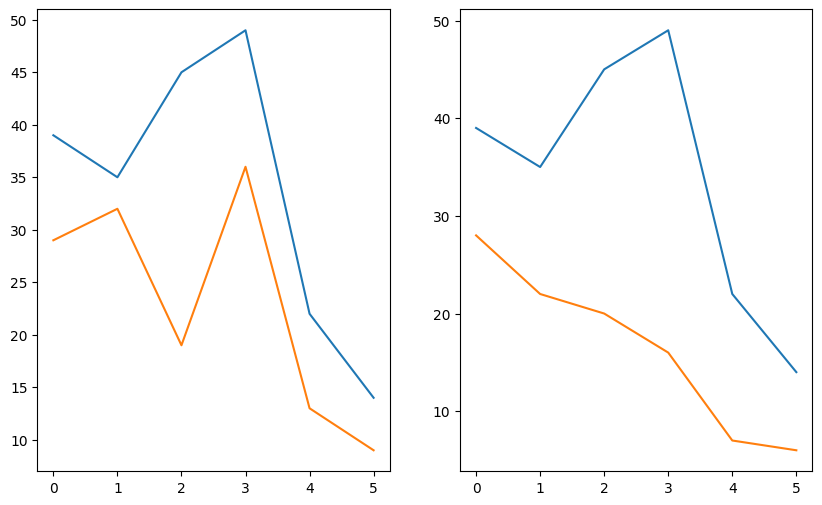

In [124]:
# plot the time series for POIs 33, 34, and 12 
# y = de_normalized(y.numpy(), NORM_METHOD, normalize_statistic)
fig, ax = plt.subplots(1, 2,figsize=(10, 6))
ax[0].plot(y[0, :, a])
ax[0].plot(y[0, :, b])
ax[1].plot(y[0, :, a])
ax[1].plot(y[0, :, c])

In [125]:
fig = px.scatter_mapbox(
    df.iloc[[a, b, c]], 
    lat="latitude", 
    lon="longitude", 
    hover_name="location_name", 
    hover_data=["phone_number", "open_hours"], 
    zoom=10
)

# Set the map style
fig.update_layout(mapbox_style="open-street-map")

# Update the marker properties
fig.update_traces(marker=dict(size=10, opacity=0.7))

# Show the plot
fig.show()

In [105]:
# Find starbucks locations in df
df.iloc[:END_POI][df.iloc[:END_POI]['location_name'].str.contains('Starbucks')]

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
135,sg:bf9cc50e6cfd4b25b07d3b363795fcec,"[213, 282, 306, 318, 294, 58, 37, 319, 335, 31...","[0, 0, 0, 0, 0, 4, 9, 7, 9, 15, 14, 15, 14, 59...",99627,Starbucks,6400 Fannin St Ste 104,Houston,TX,77030.0,US,SG_BRAND_f116acfe9147494063e58da666d1d57e,Starbucks,NaN,Restaurants and Other Eating Places,Snack and Nonalcoholic Beverage Bars,722515.0,29.715108,-95.397362,1.713797e+10,"{ ""Mon"": [[""4:30"", ""19:00""]], ""Tue"": [[""4:30"",...","Snacks,Counter Service,Dessert,Tea House,Coffe..."
285,sg:66fd384f20dd44c1b1c644e7227daf3d,"[24, 47, 20, 65, 37, 40, 8, 314, 313, 315, 294...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 9, 4, ...",60330,Starbucks,334 Melcher Hall,Houston,TX,77204.0,US,SG_BRAND_f116acfe9147494063e58da666d1d57e,Starbucks,NaN,Restaurants and Other Eating Places,Snack and Nonalcoholic Beverage Bars,722515.0,29.720995,-95.339488,1.713743e+10,NaN,"Snacks,Counter Service,Dessert,Tea House,Coffe..."


In [121]:
adj_mat_thresholded[285].argmax(), adj_mat_thresholded[285].argmin()

288

In [119]:
adj_mat_thresholded[135, 285]

3.301895e-05

In [113]:
df.iloc[[135, 61, 285]]

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
135,sg:bf9cc50e6cfd4b25b07d3b363795fcec,"[213, 282, 306, 318, 294, 58, 37, 319, 335, 31...","[0, 0, 0, 0, 0, 4, 9, 7, 9, 15, 14, 15, 14, 59...",99627,Starbucks,6400 Fannin St Ste 104,Houston,TX,77030.0,US,SG_BRAND_f116acfe9147494063e58da666d1d57e,Starbucks,NaN,Restaurants and Other Eating Places,Snack and Nonalcoholic Beverage Bars,722515.0,29.715108,-95.397362,1.713797e+10,"{ ""Mon"": [[""4:30"", ""19:00""]], ""Tue"": [[""4:30"",...","Snacks,Counter Service,Dessert,Tea House,Coffe..."
61,sg:760de8a09bbf4c26a84b2bb3e9481b33,"[276, 631, 624, 601, 568, 64, 27, 636, 697, 63...","[0, 0, 1, 0, 0, 4, 6, 21, 11, 6, 11, 8, 9, 134...",153880,Cypress Creek H S,9815 Grant Rd,Houston,TX,77070.0,US,NaN,NaN,NaN,Elementary and Secondary Schools,Elementary and Secondary Schools,611110.0,29.965528,-95.565529,1.281897e+10,NaN,NaN
285,sg:66fd384f20dd44c1b1c644e7227daf3d,"[24, 47, 20, 65, 37, 40, 8, 314, 313, 315, 294...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 9, 4, ...",60330,Starbucks,334 Melcher Hall,Houston,TX,77204.0,US,SG_BRAND_f116acfe9147494063e58da666d1d57e,Starbucks,NaN,Restaurants and Other Eating Places,Snack and Nonalcoholic Beverage Bars,722515.0,29.720995,-95.339488,1.713743e+10,NaN,"Snacks,Counter Service,Dessert,Tea House,Coffe..."
